# **EuroSAT Urban Expansion Estimator**

## **0. How to Run the Models**

*   CNN
    *   Drag best_model.pt into Colab session storage
    *   Run cells 1.1-1.4 and 1.6
    *   We can skip the training loop (1.5) and use the best saved model


*   Random Forest Classifier
    *   Run cells 2.1-2.5





## **1. Convolutional Neural Network (CNN)**

### 1.1 Setting up the CNN (Base Imports & Testing/Logging Functions)



In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import os
import zipfile

In [3]:
def test(network, test_loader, loss_function):
  network.eval() # Updates any network layers that behave differently in training and execution
  test_loss = 0
  num_batches = 0

  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      target = target.type(torch.FloatTensor)
      test_loss += loss_function(output, target).item()
      pred = (torch.sigmoid(output) > 0.5).float()
      num_batches += 1
  test_loss /= num_batches
  return test_loss

def logResults(epoch, num_epochs, train_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, print_interval=1000):
  if (epoch%print_interval == 0):  print('Epoch [%d/%d], Train Loss: %.4f, Test Loss: %.4f' %(epoch+1, num_epochs, train_loss, test_loss))
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  epoch_counter.append(epoch)

def graphLoss(epoch_counter, train_loss_hist, test_loss_hist, loss_name="Loss", start = 0):
  fig = plt.figure()
  plt.plot(epoch_counter[start:], train_loss_hist[start:], color='blue')
  plt.plot(epoch_counter[start:], test_loss_hist[start:], color='red')
  plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
  plt.xlabel('#Epochs')
  plt.ylabel(loss_name)

def computeLabelAccuracy(networkModel, data_loader, label_text=""):
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for data, target in data_loader:
      output = networkModel(data)
      pred = (torch.sigmoid(output) > 0.5).float() # Apply binary threshold
      target = target.float()
      correct += pred.eq(target.data.view_as(pred)).sum()
  print('\n{}: Accuracy: {}/{} ({:.2f}%)'.format(
    label_text, correct, len(data_loader.dataset),
    100.0 * correct / len(data_loader.dataset)))

def graphConfusionMatrix(test_dataset, num_samples=10000):
  data_generator = torch.utils.data.DataLoader(test_dataset, batch_size=num_samples)
  data_enumerator = enumerate(data_generator)
  _, (images,labels) = next(data_enumerator)

  with torch.no_grad():
      pred_categories = network(images) # All 10 values
      pred_labels = (torch.sigmoid(pred_categories) > 0.5).float() # Apply binary threshold

  labels = labels.float()
  conf_mat = confusion_matrix(labels.numpy(), pred_labels.numpy(), normalize = "pred")
  plt.figure(figsize=(8,5))

  class_labels = ['Non-Urban', 'Urban']

  sns.heatmap(conf_mat, annot=True, fmt="0.2f", xticklabels = class_labels, yticklabels = class_labels,
              cmap = "Reds") # Colormaps: gnuplot hot RdPu inferno viridis BuPu RdBu_r coolwarm
  plt.xlabel("Target Class")
  plt.ylabel("Predicted Class")

### 1.2 Training Functions

In [6]:
def train(network,  data_generator, loss_function, optimizer, batch_logging = 100):
  network.train() # Updates any network layers that behave differently in training and execution
  avg_loss = 0
  num_batches = 0

  for batch, (input_data, target_output) in enumerate(data_generator):
    optimizer.zero_grad()                            # Gradients need to be reset each batch
    prediction = network(input_data)                 # Forward pass: compute the output class given a image

    target_output = target_output.type(torch.FloatTensor) # Convert target output to a FloatTensor before loss calculation for BCEWithLogitsLoss compatibility

    loss = loss_function(prediction, target_output)  # Compute the loss: difference between the output and correct result
    loss.backward()                                  # Backward pass: compute the gradients of the model with respect to the loss
    optimizer.step()
    avg_loss += loss.item()
    num_batches += 1

    if ((batch+1)%batch_logging == 0): # Print info every "batch_logging" steps [NEW]
      print('Batch [%d/%d], Train Loss: %.4f' %(batch+1, len(data_generator.dataset)/len(target_output), avg_loss/num_batches))

  return avg_loss/num_batches

In [7]:
def trainAndGraph(network, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, early_stopping=True, logging_interval=1):
  # Arrays to store training history
  test_loss_history = []
  epoch_counter = []
  train_loss_history = []
  last_loss = 999999
  best_loss = 999999

  for epoch in range(num_epochs):
    avg_loss = train(network, training_generator, loss_function, optimizer)
    test_loss = test(network, testing_generator, loss_function)
    logResults(epoch, num_epochs, avg_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, logging_interval)

    if (early_stopping and test_loss > last_loss):
      break

    if (test_loss < best_loss):
      best_loss = test_loss
      torch.save(network.state_dict(), 'best_model.pt')
    last_loss = test_loss
    old_params = network.parameters()

  graphLoss(epoch_counter, train_loss_history, test_loss_history)

### 1.3 EuroSAT

In [10]:
from torch.utils.data import Subset
import random

"""
Balances the data by utilizing all of the images for urban classes and undersampling
an equal number of non-urban images
"""
def balance_dataset(binary_dataset):
  urban_indices = []
  non_urban_indices = []

  # Classify all indices as urban or non-urban
  for idx in range(len(binary_dataset)):
      _, label = binary_dataset[idx]
      if label == 1:
          urban_indices.append(idx)
      else:
          non_urban_indices.append(idx)

  # Shuffle non-urban indices
  random.seed(42)
  random.shuffle(non_urban_indices)

  # Match number of non-urban samples to urban samples
  num_urban = len(urban_indices)
  balanced_non_urban_indices = non_urban_indices[:num_urban]

  # Combine and shuffle
  balanced_indices = urban_indices + balanced_non_urban_indices
  random.shuffle(balanced_indices)

  # Create balanced subset
  return Subset(binary_dataset, balanced_indices)

In [11]:
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

urban_classes = ['Highway', 'Industrial', 'Residential']

"""
Wrapper for EuroSAT data reframed for binary classification
Binary labels: Urban = 1, Non-urban = 0
"""
class BinaryEuroSAT(torch.utils.data.Dataset):
  def __init__(self, original_dataset, class_to_idx):
    self.data = original_dataset
    self.class_to_idx = class_to_idx

  def __getitem__(self, index):
    img, label = self.data[index]
    class_name = list(self.class_to_idx.keys())[label]
    binary_label = 1 if class_name in urban_classes else 0
    return img, binary_label

  def __len__(self):
    return len(self.data)

# Define transformations
# Resize EuroSAT images to consistent size and normalize
transform = transforms.Compose([
    transforms.Resize((64, 64)), # EuroSAT images are already 64x64, but this ensures it
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize pixel values to [-1, 1] range with a mean of about 0
])

# No option for automatic train/test data with EuroSAT, so it will be split later on
euro_sat_dataset = torchvision.datasets.EuroSAT(
    root='./data',
    download=True,
    transform=transform
)

# # Modified data loading for MSI
# euro_sat_dataset = ImageFolder(root='./EuroSAT_RGB', transform=transform)

# 10 categories of land masses from EuroSAT
classes = (
    'AnnualCrop',
    'Forest',
    'HerbaceousVegetation',
    'Highway',
    'Industrial',
    'Pasture',
    'PermanentCrop',
    'Residential',
    'River',
    'SeaLake'
)

class_labels = ['Non-Urban', 'Urban']

# Image size
image_w = 64
image_h = 64

100%|██████████| 94.3M/94.3M [00:00<00:00, 194MB/s]


We can show images from the dataset. Unnormalize the images by scaling by 2 and adding 0.5. Here are the first few images with labels.

In [12]:
from torch.utils.data import random_split, Subset

torch.manual_seed(42)

# Step 1: Initial split: 70% train, 30% val+test
train_size = int(0.7 * len(euro_sat_dataset))
val_test_size = len(euro_sat_dataset) - train_size

training_dataset, val_test_dataset = random_split(
    euro_sat_dataset,
    [train_size, val_test_size],
)

# Step 2: Split 30% portion into equal halves (15% val, 15% test)
half_val_test = val_test_size // 2
val_dataset, test_dataset_placeholder = random_split(
    val_test_dataset,
    [half_val_test, val_test_size - half_val_test],
)

# Step 3: Apply BinaryEuroSAT wrapper
training_dataset = BinaryEuroSAT(training_dataset, euro_sat_dataset.class_to_idx)
val_dataset = BinaryEuroSAT(val_dataset, euro_sat_dataset.class_to_idx)
test_dataset_placeholder = BinaryEuroSAT(test_dataset_placeholder, euro_sat_dataset.class_to_idx)

# Step 4: Balance training and validation datasets
balanced_training_dataset = balance_dataset(training_dataset)
balanced_validation_dataset = balance_dataset(val_dataset)

# Step 5: Sample test set to match size of balanced validation set
# (Ensure reproducibility by using a fixed seed)
import random
random.seed(42)
indices = list(range(len(test_dataset_placeholder)))
random.shuffle(indices)
test_indices = indices[:len(balanced_validation_dataset)]
testing_dataset = Subset(test_dataset_placeholder, test_indices)

print(f"Train Size: {len(balanced_training_dataset)}\nValidation Size: {len(balanced_validation_dataset)}\nTesting Size: {len(testing_dataset)}")

Train Size: 11188
Validation Size: 2374
Testing Size: 2374


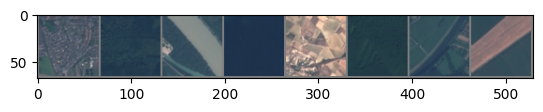

Labels: Forest, AnnualCrop, AnnualCrop, AnnualCrop, AnnualCrop, AnnualCrop, AnnualCrop, AnnualCrop


In [13]:
def imshow(img):
    img = img / 2 + 0.5 # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

num_images = 8

# Get some random training images
dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=num_images, shuffle=True)
data_iter = iter(dataloader)
images, labels = next(data_iter)

# Show images
imshow(torchvision.utils.make_grid(images))
# Print the images' respective labels
print("Labels:",', '.join('%5s' % classes[labels[j]] for j in range(num_images)))

This function will draw `num_rows` x `num_cols` images along with their predicted and actual labels

In [14]:
def drawPredictionsEuroSAT(networkModel, dataset, num_rows=6, num_cols = 10, skip_batches=0):
  # Plot some of the testing results
  data_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=num_rows*num_cols)
  data_enumerator = enumerate(data_generator)

  for i in range(skip_batches):
     _, (images,labels) = next(data_enumerator) # Skip a few batches if needed
  _, (images,labels) = next(data_enumerator)

  with torch.no_grad():
    pred_categories = networkModel(images) # All 10 values
    pred_labels = (torch.sigmoid(pred_categories) > 0.5).float() # Apply binary threshold

  labels = labels.float()

  for row in range(num_rows):
    fig = plt.figure(figsize=(num_cols+6,5)) # Adjust the plot size

    for i in range(num_cols):
      plt.subplot(1,num_cols,i+1)
      cur = i + row*num_cols
      # plt.tight_layout()
      drawColor = 'black'

      # Convert predicted and actual labels to integers for indexing into 'class_labels'
      pred_label_int = int(pred_labels[cur].item())
      actual_label_int = int(labels[cur].item())

      if pred_labels[cur].item() != labels[cur]:
        drawColor = 'red'
      img = images[cur] / 2 + 0.5 # Unnormalize
      npimg = img.numpy()
      plt.imshow(np.transpose(npimg, (1, 2, 0))) #, interpolation='none'
      plt.title(" Actual: {},\n Pred: {}".format(class_labels[pred_label_int],class_labels[actual_label_int]), color=drawColor)
      plt.xticks([])
      plt.yticks([])
      plt.xlabel("#{}".format(cur))

### 1.4 Multi-Layer CNN

In [15]:
class EuroSAT_CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # --- Convolutional Layers ---
        # Extract features from the images such as texture, layout, and structure
        # Using nn.Sequential to group several layers into a single block
        self.features = nn.Sequential(
            # Learns 32 filters over RGB 64x64 images
            # Each filter looks at a 3x3 patch
            # Keeps spatial dimensions the same
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Input: (3, 64, 64)
            # Stablize training by normalizing activations
            # Helps model converge faster and can act as a regularizer
            nn.BatchNorm2d(32),
            nn.ReLU(),                                   # Non-linearity
            # Downsamples image by taking max over each 2x2 patch
            nn.MaxPool2d(2),                             # Output: (32, 32, 32)

            # Repeat the same pattern with increasing depth and more downsampling
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),                             # Output: (64, 16, 16)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),                             # Output: (128, 8, 8)
        )

        # Adaptive pooling to reduce feature map size (safer than hardcoding dimensions)
        # Gurantees output size of (4, 4)
        self.pool = nn.AdaptiveAvgPool2d((4, 4))         # Output: (128, 4, 4)

        # Classifier
        self.classifier = nn.Sequential(
            # Converts (batch_size, 128, 4, 4) to (batch_size, 2048), making it able to pass into linear layer
            nn.Flatten(),
            # Maps the 2048 extracted features to a 256-dimensional vector, allowing for a classification decision
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            # Disable 50% of neurons to avoid overfitting and learn redundant patterns
            nn.Dropout(0.5),
            # Final output is a single logit per sample for binary classification
            nn.Linear(256, 1)
        )

    def forward(self, x):
        # Image flows through the 3 convolutional layers, spatially reduced layer, then the classifier for decision
        x = self.features(x)
        x = self.pool(x)
        x = self.classifier(x)
        # Remove the single dimension to go from (batch_size, 1) to (batch_size,) for compatibility with BCEWithLogitsLoss
        return x.squeeze(1)

### 1.5 Training Loop

In [ ]:
# Training parameters
num_epochs = 20
print_interval = 1
learning_rate = 0.0001
batch_size = 64

# Create model
network = EuroSAT_CNN()

# Set optimizer and loss function
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
loss_function = nn.BCEWithLogitsLoss()

# Load the data, and split it into batches
training_generator = torch.utils.data.DataLoader(balanced_training_dataset, batch_size=batch_size, shuffle=True)
validation_generator = torch.utils.data.DataLoader(balanced_validation_dataset, batch_size=batch_size, shuffle=False)

# Load the testing data, but don't use for hyperparameter tuning
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

print("Data Loaded")

trainAndGraph(network, training_generator, validation_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)

computeLabelAccuracy(network, training_generator, "Training Set")
computeLabelAccuracy(network, validation_generator, "Validation Set")
computeLabelAccuracy(network, testing_generator, "Testing Set")
drawPredictionsEuroSAT(network, testing_dataset, 5, 5, 0)

Data Loaded


Best model

### 1.6 Run the Best Saved Model


Training Set: Accuracy: 10492/11188 (93.78%)

Validation Set: Accuracy: 2207/2374 (92.97%)

Testing Set: Accuracy: 2228/2374 (93.85%)


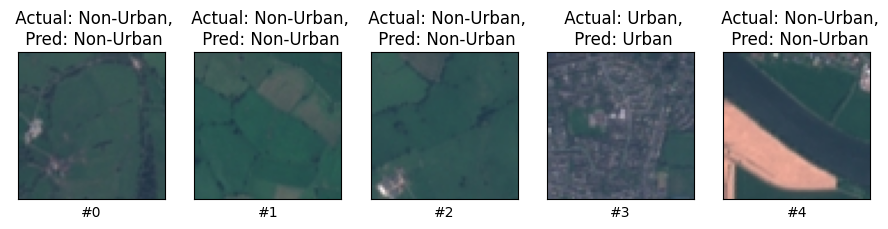

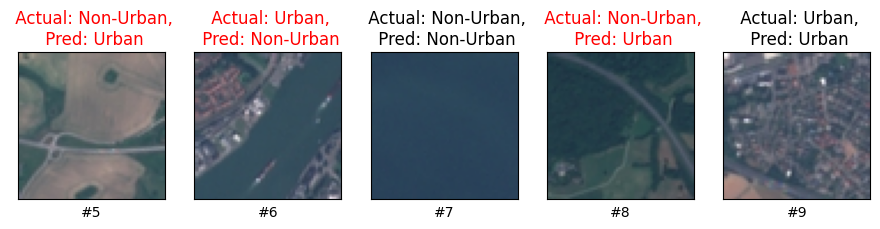

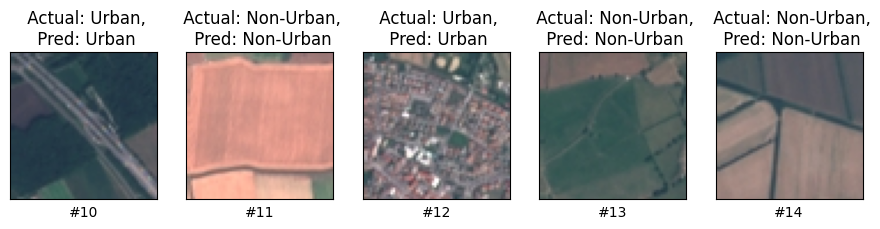

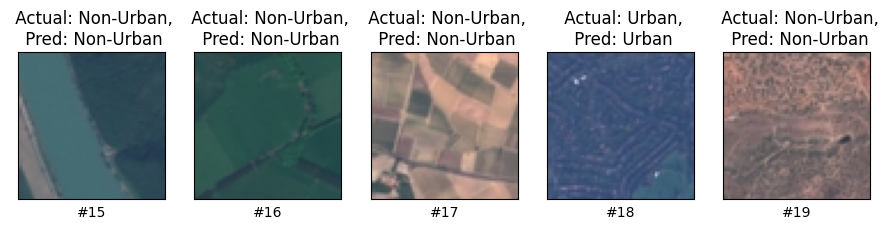

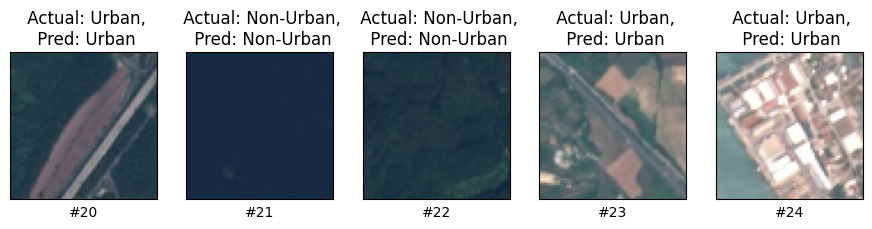

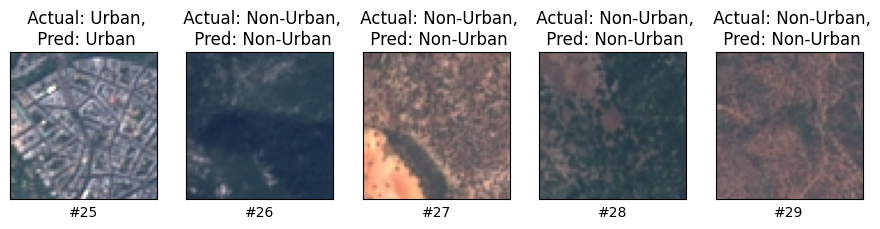

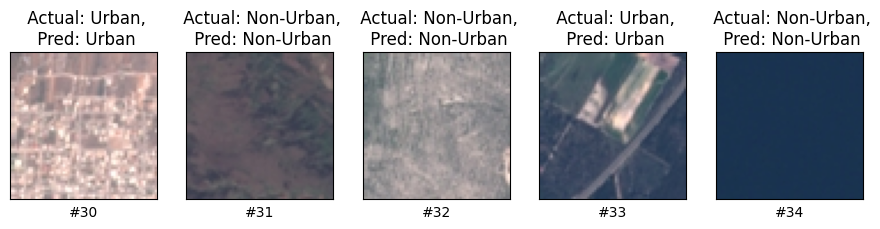

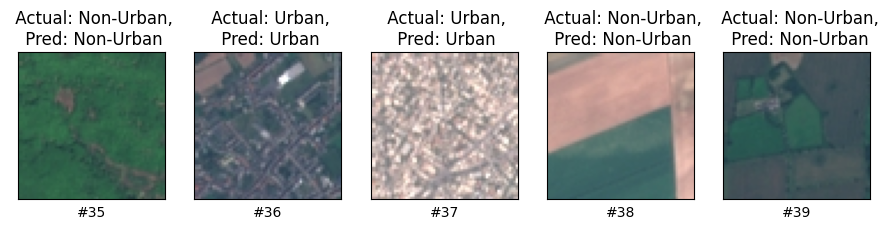

In [19]:
# Tools needed, so we don't have to run training block
batch_size = 64
training_generator = torch.utils.data.DataLoader(balanced_training_dataset, batch_size=batch_size, shuffle=True)
validation_generator = torch.utils.data.DataLoader(balanced_validation_dataset, batch_size=batch_size, shuffle=False)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

# Load the best saved network
network = EuroSAT_CNN()
network.load_state_dict(torch.load("/content/best_model.pt"))
network.eval()

# Run it to compute the stats & results
computeLabelAccuracy(network, training_generator, "Training Set")
computeLabelAccuracy(network, validation_generator, "Validation Set")
computeLabelAccuracy(network, testing_generator, "Testing Set")
drawPredictionsEuroSAT(network, testing_dataset, 8, 5, 0)

### 1.6 Multi-Layer CNN Metrics

Classification Report

In [20]:
# Set model to evaluation mode
network.eval()

y_true = []
y_pred = []
y_scores = []

with torch.no_grad():
    for images, labels in testing_generator:
        outputs = network(images)
        probs = torch.sigmoid(outputs)  # Since model outputs raw logits

        y_scores.extend(probs.cpu().numpy())
        y_pred.extend((probs > 0.5).int().cpu().numpy())
        y_true.extend(labels.cpu().numpy())

print("EuroSAT CNN Classification Report\n\n", classification_report(y_true, y_pred, target_names=["Non-Urban", "Urban"]))

EuroSAT CNN Classification Report

               precision    recall  f1-score   support

   Non-Urban       0.97      0.94      0.95      1647
       Urban       0.87      0.94      0.90       727

    accuracy                           0.94      2374
   macro avg       0.92      0.94      0.93      2374
weighted avg       0.94      0.94      0.94      2374



AUC-ROC Score & Curve

In [22]:
# Compute AUC
cnn_roc_auc = roc_auc_score(y_true, y_scores)
print(f"AUC-ROC Score: {cnn_roc_auc:.4f}")

# Plot ROC Curve
cnn_fpr, cnn_tpr, thresholds = roc_curve(y_true, y_scores)

# Commenting out because we have the combined ROC curves at the bottom of the notebook

# plt.figure(figsize=(8, 6))
# plt.plot(cnn_fpr, cnn_tpr, label=f'AUC = {cnn_roc_auc:.4f}')
# plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random guess line
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("EuroSAT CNN ROC Curve")
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

AUC-ROC Score: 0.9851


Confusion matrix visualization

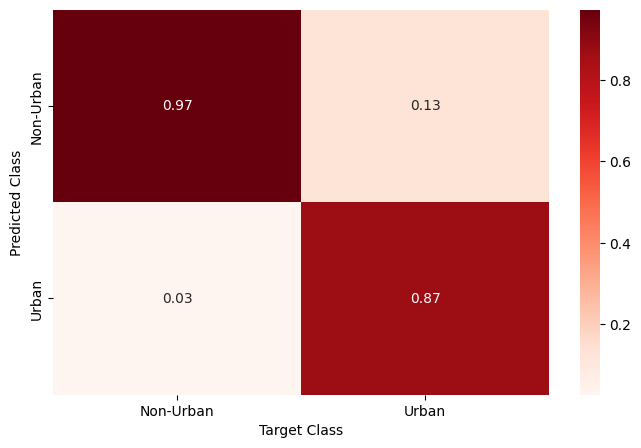

In [23]:
graphConfusionMatrix(testing_dataset)

## **2. Random Forest Classifier (RFC)**


### 2.1 Setting up the RFC (Base Imports)

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

### 2.2 Convert Image Data to Feature Vectors

In [27]:
def extract_features(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)
    features_list = []
    labels_list = []

    for images, labels in loader:
        # Flatten images: (batch_size, 3, 64, 64) -> (batch_size, 3 * 64 * 64)
        images = images.view(images.size(0), -1)
        features_list.append(images.numpy())
        labels_list.append(labels.numpy())

    X = np.vstack(features_list)
    y = np.hstack(labels_list)

    return X, y

### 2.3 Extract Features from the Data

In [28]:
X_training, y_training = extract_features(balanced_training_dataset)
X_validation, y_validation = extract_features(balanced_validation_dataset)
X_testing, y_testing = extract_features(testing_dataset)

### 2.4 Training the RCF

In [29]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_training, y_training)

y_pred = random_forest.predict(X_testing)

### 2.5 RCF Metrics

Accuracy computation

In [30]:
accuracy = accuracy_score(y_testing, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

Random Forest Accuracy: 0.8345


Classification report

In [31]:
print("EuroSAT Random Forest Classification Report\n\n", classification_report(y_testing, y_pred, target_names=["Non-Urban", "Urban"]))

EuroSAT Random Forest Classification Report

               precision    recall  f1-score   support

   Non-Urban       0.95      0.80      0.87      1647
       Urban       0.67      0.91      0.77       727

    accuracy                           0.83      2374
   macro avg       0.81      0.85      0.82      2374
weighted avg       0.87      0.83      0.84      2374



AUC-ROC Score & Curve

In [32]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_scores = random_forest.predict_proba(X_testing)[:, 1]
rf_fpr, rf_tpr, _ = roc_curve(y_testing, y_scores)
rf_roc_auc = auc(rf_fpr, rf_tpr)

# Commenting out because we have the combined ROC curves at the bottom of the notebook

# plt.figure()
# plt.plot(rf_fpr, rf_tpr, label=f"AUC = {rf_roc_auc:.4f}")
# plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("EuroSAT Random Forest ROC Curve")
# plt.legend(loc="lower right")
# plt.grid(True)
# plt.show()

Confusion matrix

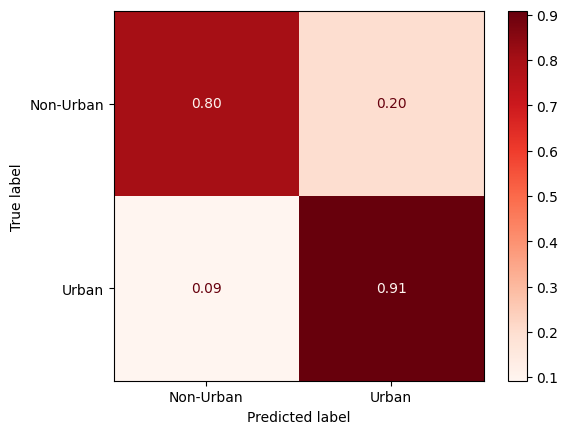

In [ ]:
confusion = confusion_matrix(y_testing, y_pred, normalize='true') # Normalize for true frequency
display = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=['Non-Urban', 'Urban'])
display.plot(cmap="Reds", values_format=".2f")
plt.show()

## 3. Combined Metrics Visualization

AUC-ROC Curve

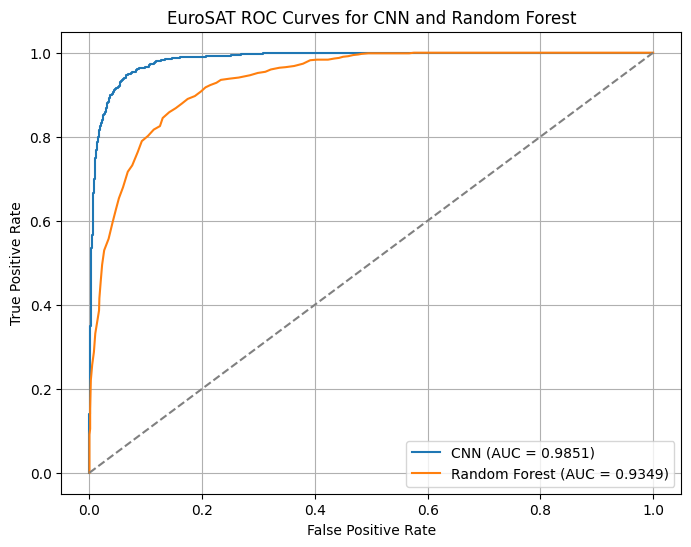

In [33]:
plt.figure(figsize=(8, 6))
plt.plot(cnn_fpr, cnn_tpr, label=f'CNN (AUC = {cnn_roc_auc:.4f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("EuroSAT ROC Curves for CNN and Random Forest")

plt.legend()
plt.grid(True)

plt.show()